In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.nn import knn_graph
from mmwave_model_integrator.torch_training.models.DynamicEdgeConvGnn import RadarDynamicClassifier

def visualize_dynamic_layers(model, x, batch=None):
    """
    Visualizes the difference between the 'Physical' graph (Layer 1)
    and the 'Semantic' graph (Layer 2).
    """
    model.eval()
    k = model.k  # Ensure your model stores 'self.k = k' in __init__
    
    with torch.no_grad():
        # --- LAYER 1: Physical Geometry ---
        # DynamicEdgeConv Layer 1 finds neighbors based on raw x,y,z input
        edge_index_1 = knn_graph(x, k=k, batch=batch, loop=False)
        
        # Get the features output by layer 1 to feed into layer 2
        # (We assume your model structure matches the RadarDynamicClassifier we built)
        x1 = model.conv1(x, batch)

        # --- LAYER 2: Semantic/Feature Geometry ---
        # DynamicEdgeConv Layer 2 finds neighbors based on FEATURES (x1)
        # This is where the "Teleportation" happens
        edge_index_2 = knn_graph(x1, k=k, batch=batch, loop=False)

    # --- PLOTTING ---
    fig = plt.figure(figsize=(16, 8))
    
    # Extract points as numpy for plotting
    pos = x[:, :3].cpu().numpy() # Just x,y,z
    
    # Helper to draw edges
    def plot_edges(ax, edges, title, color, alpha=0.1):
        ax.scatter(pos[:,0], pos[:,1], pos[:,2], c='black', s=5, label='Points')
        ax.set_title(title)
        ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
        
        # Draw lines
        start_pts = pos[edges[0]]
        end_pts = pos[edges[1]]
        
        # We plot a random subset of edges to avoid clutter if N is large
        num_edges = edges.shape[1]
        if num_edges > 2000:
            indices = np.random.choice(num_edges, 2000, replace=False)
            start_pts = start_pts[indices]
            end_pts = end_pts[indices]
            
        # Draw lines as a collection (faster than looping)
        for i in range(len(start_pts)):
            ax.plot([start_pts[i,0], end_pts[i,0]], 
                    [start_pts[i,1], end_pts[i,1]], 
                    [start_pts[i,2], end_pts[i,2]], c=color, alpha=alpha)

    # Plot 1: Physical Neighbors
    ax1 = fig.add_subplot(121, projection='3d')
    plot_edges(ax1, edge_index_1.cpu().numpy(), f"Layer 1: Physical (k={k})\n(Short, Local connections)", 'blue')

    # Plot 2: Semantic Neighbors
    ax2 = fig.add_subplot(122, projection='3d')
    plot_edges(ax2, edge_index_2.cpu().numpy(), f"Layer 2: Semantic (k={k})\n(Learned 'Teleportation')", 'red')

    plt.tight_layout()
    plt.show()

Visualizing 250 points...


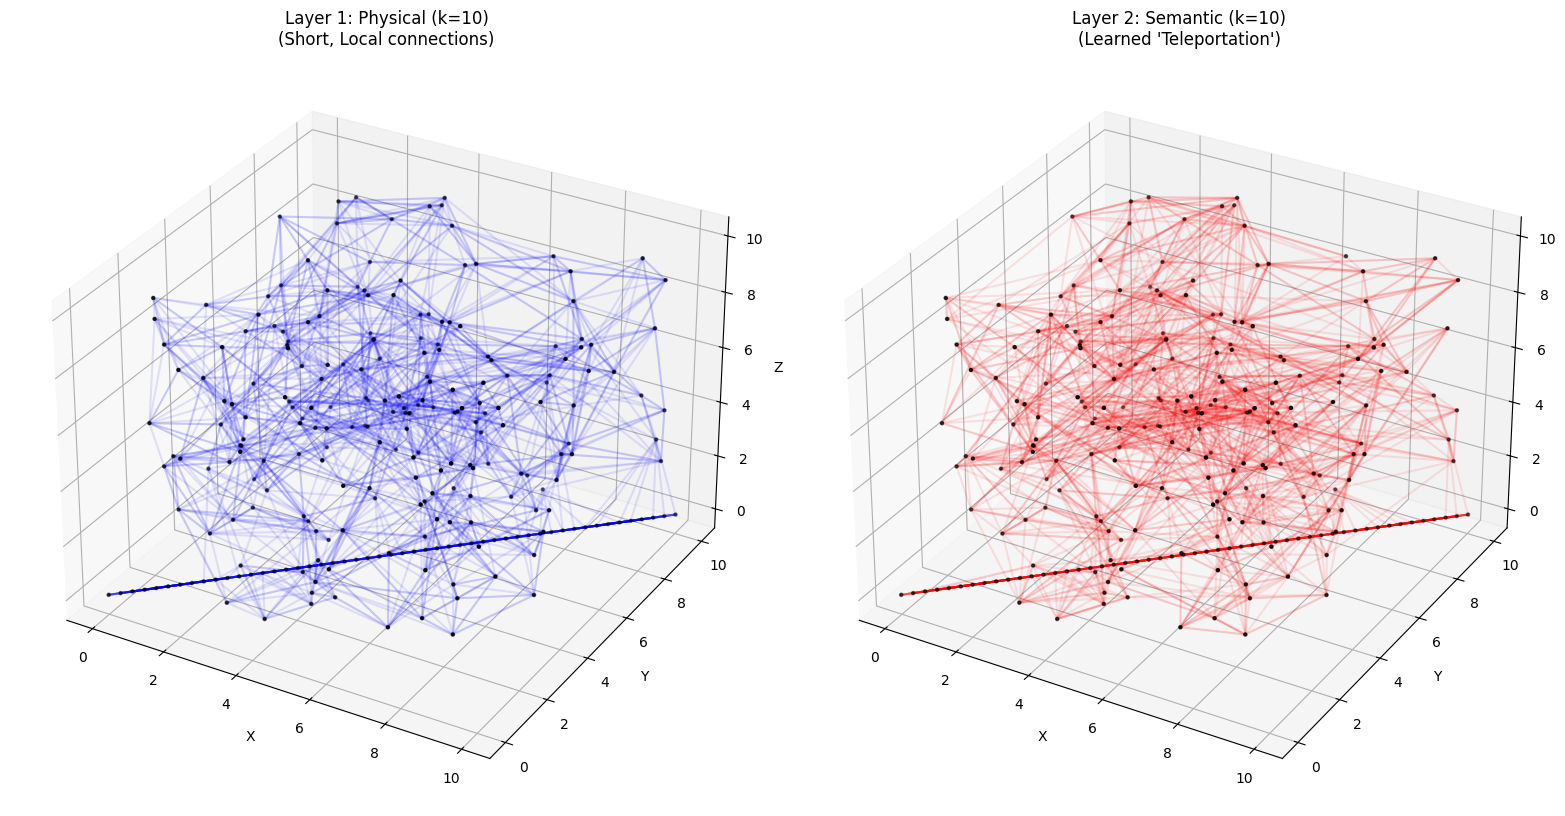

In [3]:
# (Using the class definition from our previous conversation)
model = RadarDynamicClassifier(k=10) 

# 2. Create Dummy Data: A "Line" (Track) and "Box" (Noise)
# Track: 50 points in a line
track = torch.zeros(50, 4)
track[:, 0] = torch.linspace(0, 10, 50) # X moves 0 to 10
track[:, 1] = torch.linspace(0, 10, 50) # Y moves 0 to 10

# Noise: 200 random points scattered
noise = torch.rand(200, 4) * 10 

# Combine
x = torch.cat([track, noise], dim=0)
batch = torch.zeros(x.shape[0], dtype=torch.long) # Single batch

print(f"Visualizing {x.shape[0]} points...")
visualize_dynamic_layers(model, x, batch)